# Final Project - CNN model
In this notebook we preprocess the car data and build a CNN classifier.

## Packages And Functions

In [21]:
# Packages
from google.colab import drive
import os
from zipfile import ZipFile
from PIL import Image
import numpy as np
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.layers import (Conv2D,
                          Dense,
                          Flatten,
                          AveragePooling2D,
                          Input,
                          Dropout,
                          BatchNormalization)
from keras.models import Sequential, Model
from keras.utils import to_categorical

# Document variables
IMAGE_SIZE = (128, 128)
RANDOM_STATE = 42

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Path to the zip file
zip_file_path = '/content/drive/MyDrive/Deep_Learning/data.zip'

# Extract images from the zip file
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/images')

# Path to the extracted images folder
images_folder_path = '/content/images/data'

# Load images with their labels
images = []
labels = []

for folder_name in os.listdir(images_folder_path):
    folder_path = os.path.join(images_folder_path, folder_name)
    if os.path.isdir(folder_path):
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            image = Image.open(image_path)
            image = image.resize(IMAGE_SIZE)
            image = np.array(image) / 255.0
            image = np.array(image)
            images.append(image)
            labels.append(folder_name)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load in the data

First we load in the data, containing images of cars from different sides. These are loaded in with their label into a dataframe

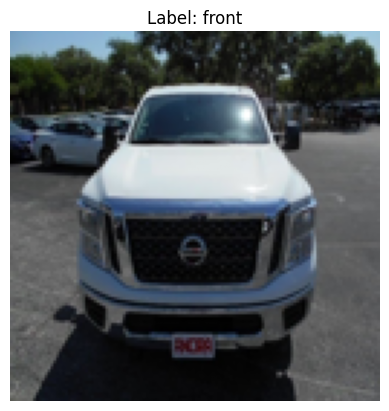

In [3]:
# plot first image
plt.imshow(images[3005])
plt.title('Label: ' + labels[3005])
plt.axis('off')
plt.show()

In [4]:
# Check if the data is balanced
unique, counts = np.unique(labels, return_counts=True)

np.asarray((unique, counts)).T

array([['3_4th_driver_side_front', '500'],
       ['3_4th_driver_side_rear', '500'],
       ['3_4th_passenger_side_front', '500'],
       ['3_4th_passenger_side_rear', '500'],
       ['driver_side', '500'],
       ['front', '500'],
       ['passenger_side', '500'],
       ['rear', '500'],
       ['unknown', '500']], dtype='<U26')

## Split the data
The data is normalized, one-hot encoded and split in train, validation and test data.

In [5]:
X = images
# One-hot encoding
le = LabelEncoder().fit(labels)
y = le.transform(labels)
yy = to_categorical(y)

In [6]:
# Data splitting
X_temp, X_test, y_temp, y_test = train_test_split(X, yy, test_size=0.2, random_state = RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state = RANDOM_STATE)

# Convert image data to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

# Size data sets
print('Train set:', len(X_train))
print('Validation set:', len(X_val))
print('Test set:', len(X_test))

Train set: 2700
Validation set: 900
Test set: 900


## CNN model
We will be constructing a CNN model to classify the images.
Architecture was derived from <a href="(https://www.learndatasci.com/tutorials/convolutional-neural-networks-image-classification">learndatasci.com</a>

In [22]:
IMAGE_SIZE = (128,128) + (3,)
# The model

def CNN(input_shape=IMAGE_SIZE, num_classes=9):
    model = Sequential()
    model.add(Input(input_shape))
    model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(Dropout(0.2))
    model.add(AveragePooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [23]:
# training the model
model = CNN()
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
85/85 [==============================] - 15s 125ms/step - loss: 2.1789 - accuracy: 0.1648 - val_loss: 1.9506 - val_accuracy: 0.2567
Epoch 2/10
85/85 [==============================] - 9s 103ms/step - loss: 2.0075 - accuracy: 0.1989 - val_loss: 1.7993 - val_accuracy: 0.3511
Epoch 3/10
85/85 [==============================] - 9s 104ms/step - loss: 1.7123 - accuracy: 0.3296 - val_loss: 1.2229 - val_accuracy: 0.5500
Epoch 4/10
85/85 [==============================] - 9s 106ms/step - loss: 1.4284 - accuracy: 0.4315 - val_loss: 0.9652 - val_accuracy: 0.7000
Epoch 5/10
85/85 [==============================] - 9s 107ms/step - loss: 1.2188 - accuracy: 0.5074 - val_loss: 0.7597 - val_accuracy: 0.7433
Epoch 6/10
85/85 [==============================] - 10s 117ms/step - loss: 1.0620 - accuracy: 0.5678 - val_loss: 0.7200 - val_accuracy: 0.8156
Epoch 7/10
85/85 [==============================] - 9s 111ms/step - loss: 0.9369 - accuracy: 0.6326 - val_loss: 0.5887 - val_accuracy: 0.8267
Epoc

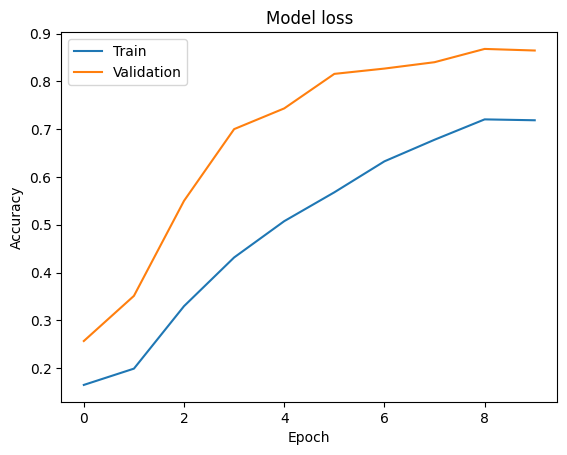

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Testing model

In [25]:
y_test_pred = model.predict(X_test)

29/29 [==============================] - 1s 20ms/step


In [26]:
predictions = np.argmax(y_test_pred, axis=1)
true = np.argmax(y_test, axis=1)
print("Predictions")
print(predictions)
print("True labels")
print(true)

Predictions
[7 8 4 6 0 8 6 0 6 8 0 7 8 2 1 8 1 3 4 6 7 6 5 8 3 2 6 2 5 1 5 5 0 0 3 4 6
 6 0 8 0 0 4 5 7 7 4 8 7 4 5 5 6 7 8 8 0 0 6 2 3 3 2 7 0 4 4 0 7 0 8 8 6 7
 4 1 5 0 4 5 6 0 6 6 4 1 6 7 2 8 2 5 3 2 6 1 3 7 4 4 7 4 3 7 5 6 4 8 1 5 8
 6 3 6 7 3 5 3 5 7 0 4 4 7 6 3 3 4 8 7 1 0 1 8 6 3 1 4 0 5 8 4 5 0 0 4 3 7
 0 3 8 2 1 3 0 7 6 0 0 7 2 6 0 0 6 5 8 2 0 8 8 7 2 3 1 2 3 2 2 4 8 8 0 2 4
 7 2 1 1 4 0 1 8 2 3 7 0 7 3 2 7 6 2 8 7 6 8 8 0 4 2 2 3 0 7 1 6 1 4 6 3 5
 5 0 4 0 8 5 1 0 5 3 7 0 8 5 8 5 7 1 4 4 5 5 5 0 3 5 7 7 2 4 8 6 8 8 5 5 6
 1 7 0 0 0 6 7 0 5 3 4 8 1 8 7 5 1 0 8 6 5 0 5 1 8 7 5 4 4 1 4 1 8 2 6 4 8
 7 5 4 6 1 0 1 5 7 4 8 1 1 2 7 0 6 5 0 7 4 0 5 3 7 1 4 1 6 8 6 8 1 5 0 8 6
 2 0 4 4 7 1 8 1 7 0 2 2 3 7 0 5 7 0 5 8 6 7 7 7 6 8 2 5 8 0 0 2 3 7 2 7 2
 1 4 5 4 5 0 6 3 6 2 7 7 3 3 6 5 0 7 5 2 0 0 7 0 2 5 0 2 2 8 2 7 7 5 0 1 7
 6 3 0 8 1 5 4 1 6 7 0 6 2 8 3 7 0 5 4 1 5 2 0 2 1 6 7 4 3 8 7 2 3 5 3 2 0
 7 2 1 0 3 7 1 3 3 7 2 2 4 8 3 3 2 1 7 4 7 0 0 7 6 4 2 1 5 1 4 0 0 8 6 8 4
 7 3 8 2 5 1 

Test Accuracy: 0.85


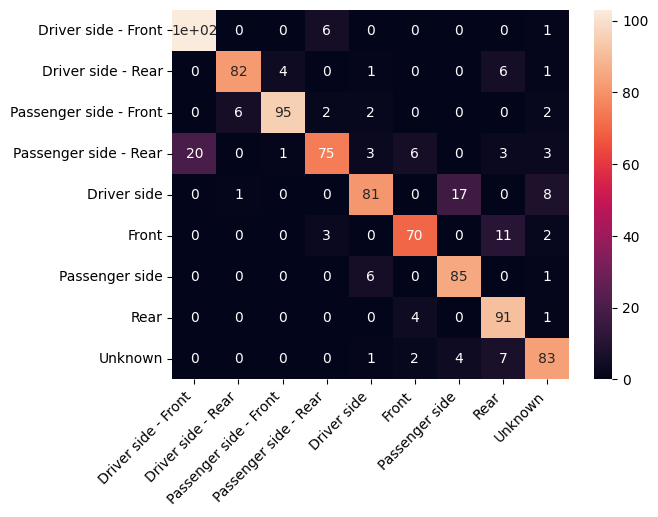

In [31]:
print("Test Accuracy:", accuracy_score(true, predictions))
cf = confusion_matrix(true, predictions)
labeling = ["Driver side - Front",
            "Driver side - Rear",
            "Passenger side - Front",
            "Passenger side - Rear",
            "Driver side",
            "Front",
            "Passenger side",
            "Rear",
            "Unknown"]
sns.heatmap(cf, annot=True, yticklabels=labeling, xticklabels=labeling)
plt.xticks(rotation=45,  ha='right')
plt.show()